In [14]:
import pytorch_lightning as pl
import textdistance as td
import numpy as np
import argparse
import torch
from torch import nn
import torch.nn.functional as F
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

from tokenizers import ByteLevelBPETokenizer

from tokenizers.processors import BertProcessing
import pandas as pd



from transformers import (

    GPT2Tokenizer,
    GPT2LMHeadModel
)

from transformers import (

    GPT2Tokenizer,
    GPT2LMHeadModel,

)

/Users/weijiechua/miniforge3/envs/gen/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/weijiechua/miniforge3/envs/gen/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Users/weijiechua/miniforge3/envs/gen/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/weijiechua/miniforge3/envs/gen/lib/python3.8/lib-dynload/../../libpng16.16.dylib' (no such file), '/Users/weijiechua/miniforge3/envs/gen/bin/../lib/libpng16.16.dylib' (no such file), '/usr/local/lib/libpng16.16.dylib' (no such file), '/usr/lib/libpng16.16.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/weijiechua/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
import numpy as np

In [15]:
from transformers import (

    GPT2Tokenizer,
    GPT2LMHeadModel
)

from transformers import (

    GPT2Tokenizer,
    GPT2LMHeadModel,

)

#Load pre-trained GPT2 language model weights
with torch.no_grad():
    gptmodel = GPT2LMHeadModel.from_pretrained('gpt2')
    gptmodel.eval()

#Load pre-trained GPT2 tokenizer
gpttokenizer = GPT2Tokenizer.from_pretrained('gpt2')

#simple tokenizer + stemmer
regextokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemmer = nltk.stem.PorterStemmer()



In [20]:
def perplexity(sentence):
    tokenize_input = gpttokenizer.encode(sentence)
    tensor_input = torch.tensor([tokenize_input])
    with torch.no_grad():
        loss = gptmodel(tensor_input, labels=tensor_input)[0]
    return np.exp(loss.detach().numpy())


def repetition_penalty(sentence):
    word_list = regextokenizer.tokenize(sentence.lower())
    filtered_words = [word for word in word_list if word not in stopwords.words('english')]
    stem_list = [stemmer.stem(word) for word in filtered_words]
    penalty = 0
    visited = []
    for w in stem_list:
        if w not in visited:
            visited.append(w)
        else:
            penalty += 0.01
    return penalty


def fluency_score(sentence):
    ppl = perplexity(sentence)
    penalty = repetition_penalty(sentence)
    score = (1 / ppl) - penalty
    return score

In [28]:
fluency_score("hello are you feeling?")

0.012032980899460548

In [72]:
df = pd.read_excel("../data/survey_data/combined_data/sat_data_combined.xlsx", index_col=0)

In [74]:
df = df.iloc[:10]

In [75]:
df_col = list(df['A01'].dropna().values)

In [76]:
curr_sentence = df_col[0]

In [77]:
prev_df = pd.DataFrame([curr_sentence],columns=['sentences'])

In [78]:
prev_df['score'] = 0

In [79]:
prev_df

,sentences,score
0,How do you feel?,0


In [80]:
df_columns  = df.columns

In [81]:
#full_empathy_list = []
full_fluency_list = []
#full_novelty_list = []

for i, col in enumerate(df_columns):
    print("==============================Current column: {col}=======================================")
    possible_options = pd.DataFrame(df.loc[:, [col]].dropna())
    best_score = 0
    empathy_list = []
    fluency_list = []
    novelty_list = []
    for index, row in possible_options.iterrows():
        sentence = row.values[0]
        #empathy = classifiers.empathy_score(sentence)
        fluency = fluency_score(sentence)
        #novelty = classifiers.novelty_score(sentence, prev_df)
        #score = empathy + 0.75*fluency + 2*novelty
        
        #empathy_list.append(empathy.item())
        fluency_list.append(fluency)
        #novelty_list.append(novelty)
        #score = classifiers.get_sentence_score(sentence, prev_df)
        score = fluency
        if score > best_score:
            best_sentence = sentence
            best_score = score
    print(f"Best sentence: {best_sentence}, {'{:.2f}'.format(best_score)}")
    best_score = best_score
    s2 = pd.DataFrame.from_records([{"sentences": best_sentence, "score": best_score}])
    prev_df = pd.concat([prev_df, s2], ignore_index=True)
    #prev_df = prev_df.append({"sentences": best_sentence}, ignore_index=True)
    
    #full_empathy_list.append(empathy_list)
    full_fluency_list.append(fluency_list)
    #full_novelty_list.append(novelty_list)

==============================Current column: {col}=======================================
Best sentence: How are you feeling right now?, 0.14
==============================Current column: {col}=======================================
Best sentence: Do you think this is how you feel at this time?, 0.06
==============================Current column: {col}=======================================
Best sentence: Would you say the emotion is positive or negative?, 0.04
==============================Current column: {col}=======================================
Best sentence: Now, let's take a moment to go through Exercise 9 so that I can help you better understand how to overcome any negative feelings that you might be experiencing., 0.05
==============================Current column: {col}=======================================
Best sentence: Do you feel like you are compassionate towards your childhood self?, 0.02
==============================Current column: {col}==============================

Best sentence: Now think about this. Sometimes children make unreasonable requests. When they don't get it, they will be upset. It is the responsibility of our adult self to teach them to bear with it, and deal with the situation with maturity. Let us practice exercises 17 and 18 (Identifying personal resentments and committing to constructive actions), 0.02
==============================Current column: {col}=======================================
Best sentence: Have you ever felt that the best possible choice of action may not be your first instinct or something that the childhood self wants, but instead a process that requires a degree of discipline or maturity?, 0.02
==============================Current column: {col}=======================================
Best sentence: Amazing work! You have proven that you exhibit foresighted compassion, and now it's time to utilise it. Navigate to AUC to learn what you can do by clicking MAIN NODE., 0.01
==============================Current col

In [104]:
import itertools
full_fluency_list2 = list(itertools.chain(*full_fluency_list))

In [105]:
full_fluency_list_np = np.array(full_fluency_list2)

In [106]:
np.mean(full_fluency_list_np)

0.01397373243038269

In [107]:
np.max(full_fluency_list_np)

0.13702384479858398

In [108]:
np.min(full_fluency_list_np)

-0.1016547866182059

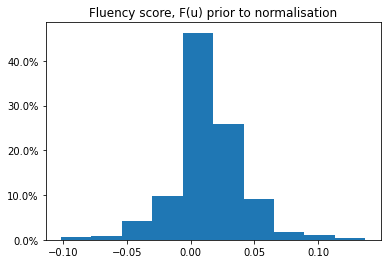

In [119]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
#_ = plt.hist(full_fluency_list_np, bins='auto')  # arguments are passed to np.histogram
plt.hist(full_fluency_list_np, weights=np.ones(len(full_fluency_list_np)) / len(full_fluency_list_np))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Fluency score, F(u) prior to normalisation")
#Text(0.5, 1.0, "Histogram with 'auto' bins")
plt.show()

In [120]:
full_fluency_list_np

array([ 6.05267949e-02,  8.50652339e-02,  8.55693454e-02,  1.01596829e-01,
        1.37023845e-01,  9.23225111e-02,  6.05267949e-02,  6.05267949e-02,
        1.40360316e-02,  7.59662959e-02,  4.97913180e-03,  8.84342337e-04,
        2.61010075e-02,  5.07069698e-03,  8.72996395e-04,  1.04884027e-03,
        4.06490727e-02,  6.09264495e-02,  2.73158886e-02,  9.10080591e-03,
        1.13049628e-02,  1.98925572e-02,  2.35485425e-02,  2.06164454e-02,
        1.70944295e-02,  3.05942553e-02,  3.67985213e-02,  1.13049628e-02,
        1.63405546e-02,  1.13049628e-02,  4.22495241e-03,  3.40956860e-03,
        5.45404026e-02,  1.68317887e-02,  3.32971280e-03,  2.25029815e-03,
        6.80213929e-03,  1.85003276e-02,  3.88758649e-03,  1.59098402e-02,
        1.06811968e-02,  1.37282754e-02,  1.50036836e-02,  1.10163451e-02,
        1.10163451e-02,  1.92371226e-02,  2.08393187e-02,  1.18100704e-02,
        8.80400785e-03,  1.18100704e-02,  2.13239640e-02,  2.34802296e-02,
       -4.44866143e-03,  

In [130]:
full_fluency_list_np2 = full_fluency_list_np + 0.11

In [132]:
np.min(full_fluency_list_np2)

0.0083452133817941

In [133]:
np.max(full_fluency_list_np2)

0.24702384479858397

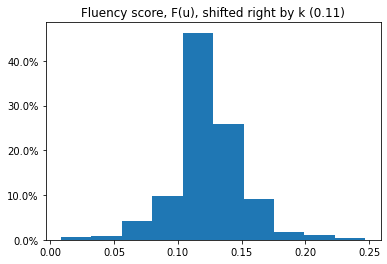

In [140]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
#_ = plt.hist(full_fluency_list_np, bins='auto')  # arguments are passed to np.histogram
plt.hist(full_fluency_list_np2, weights=np.ones(len(full_fluency_list_np2)) / len(full_fluency_list_np2))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Fluency score, F(u), shifted right by k (0.11)")
#Text(0.5, 1.0, "Histogram with 'auto' bins")
plt.show()

In [137]:
full_fluency_list_np3 = full_fluency_list_np2/ 0.247

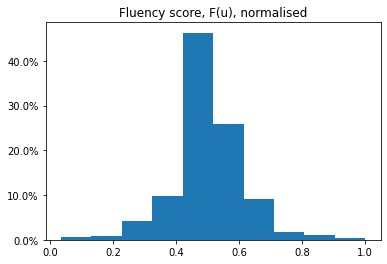

In [139]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
#_ = plt.hist(full_fluency_list_np, bins='auto')  # arguments are passed to np.histogram
plt.hist(full_fluency_list_np3, weights=np.ones(len(full_fluency_list_np3)) / len(full_fluency_list_np3))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Fluency score, F(u), normalised")
#Text(0.5, 1.0, "Histogram with 'auto' bins")
plt.show()